# 여자친구 선물 워드 클라우드 만들기

In [1]:
import time 
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

from bs4 import BeautifulSoup
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
from matplotlib import rc
%matplotlib inline
# 한글폰트 사용
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)
import nltk
import konlpy
from konlpy.tag import Okt
from konlpy.corpus import kobill
from wordcloud import WordCloud
from PIL import Image

### 셀레니움 활용해서 네이버 지식in 크롤링

#### 한 가지 질문에 대한 답변 가져오기

In [2]:
driver = webdriver.Chrome('../05.Crawling/chromedriver')
driver.maximize_window()
driver.get('https://www.naver.com/')
time.sleep(2)
driver.find_element_by_xpath('//*[@id="query"]').send_keys('여자친구 선물')
time.sleep(2)
driver.find_element_by_xpath('//*[@id="search_btn"]').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="lnb"]/div[1]/div/ul/li[4]/a').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="main_pack"]/section[1]/div/ul/li[2]/div/div[1]/div/a').click()
time.sleep(2)
driver.switch_to.window(driver.window_handles[-1]) # 새로 열린 탭으로 이동
time.sleep(2)
driver.find_element_by_xpath('//*[@id="nextPageButton"]').click() # 5개 이상 답변일 경우 더보기 버튼 누르기
time.sleep(2)
answers = driver.find_elements_by_class_name("answer-content__item._contentWrap._answer")
texts = ''
print(len(answers))
for a in answers: 
    paras = a.find_elements_by_tag_name('p')
    for p in paras:
        texts += p.text+'\n'
driver.quit()

10


#### 1페이지 질문 모두 답변 가져오기

In [3]:
driver = webdriver.Chrome('../05.Crawling/chromedriver')
driver.maximize_window()
driver.get('https://www.naver.com/')
time.sleep(2)
driver.find_element_by_xpath('//*[@id="query"]').send_keys('여자친구 선물')
time.sleep(2)
driver.find_element_by_xpath('//*[@id="search_btn"]').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="lnb"]/div[1]/div/ul/li[4]/a').click()
time.sleep(2)
answer_list = driver.find_elements_by_css_selector('.bx._svp_item')
time.sleep(2)
texts = ''
for i in range(1,len(answer_list)+1):
    driver.find_element_by_xpath(f'//*[@id="main_pack"]/section[1]/div/ul/li{[i]}/div/div[1]/div/a').click()
    time.sleep(2)
    driver.switch_to.window(driver.window_handles[-1]) # 새로 열린 탭으로 이동
    time.sleep(2)
    try:
        while driver.find_element_by_xpath('//*[@id="nextPageButton"]'):
            driver.find_element_by_xpath('//*[@id="nextPageButton"]').click() # 5개 이상 답변일 경우 더보기 버튼 누르기
    except:
        time.sleep(1)
    time.sleep(2)
    answers = driver.find_elements_by_class_name("answer-content__item._contentWrap._answer")
    for a in answers: 
        paras = a.find_elements_by_tag_name('p')
        for p in paras:
            texts += p.text+'\n'
    driver.switch_to.window(driver.window_handles[0]) # 질문 탭으로 이동
driver.quit()

#### 모든 페이지 크롤링

In [4]:
from tqdm import tqdm_notebook

In [5]:
driver = webdriver.Chrome('../05.Crawling/chromedriver')
driver.maximize_window()
driver.get('https://www.naver.com/')
time.sleep(2)
driver.find_element_by_xpath('//*[@id="query"]').send_keys('여자친구 선물')
time.sleep(2)
driver.find_element_by_xpath('//*[@id="search_btn"]').click()
time.sleep(2)
driver.find_element_by_xpath('//*[@id="lnb"]/div[1]/div/ul/li[4]/a').click()
time.sleep(2)
pages = driver.find_element_by_css_selector('.sc_page_inner')
a_tags = pages.find_elements_by_tag_name('a')
page_list = []
for a in a_tags:
    page_list.append(a.get_attribute('href'))
for page in tqdm_notebook(page_list):
    driver.get(page)
    time.sleep(2)
    answer_list = driver.find_elements_by_css_selector('.bx._svp_item')
    time.sleep(2)
    texts = ''
    for i in range(1,len(answer_list)+1):
        driver.find_element_by_xpath(f'//*[@id="main_pack"]/section[1]/div/ul/li{[i]}/div/div[1]/div/a').click()
        time.sleep(2)
        driver.switch_to.window(driver.window_handles[-1]) # 새로 열린 탭으로 이동
        time.sleep(2)
        try:
            while driver.find_element_by_xpath('//*[@id="nextPageButton"]'):
                driver.find_element_by_xpath('//*[@id="nextPageButton"]').click() # 5개 이상 답변일 경우 더보기 버튼 누르기
        except:
            time.sleep(1)
        time.sleep(2)
        answers = driver.find_elements_by_class_name("answer-content__item._contentWrap._answer")
        for a in answers: 
            paras = a.find_elements_by_tag_name('p')
            for p in paras:
                texts += p.text+'\n'
        driver.switch_to.window(driver.window_handles[0]) # 질문 탭으로 이동
driver.quit()

In [6]:
f = open("./result/present_text.txt", 'w',encoding='utf8')
f.write(texts)
f.close()

### 크롤링 결과 바탕으로 워드 클라우드 그리기

In [7]:
okt = Okt()
tokens_ko = okt.nouns(texts)
tokens_ko[:10]

['답변', '저', '집', '순이', '향', '취향', '알', '향초', '세트', '집']

In [8]:
ko = nltk.Text(tokens_ko, name='여자친구 선물')
print(len(ko.tokens))
print(len(set(ko.tokens)))

3238
840


In [9]:
# 빈도수 상위 100개
ko = nltk.Text(tokens_ko, name='여자친구 선물')
ko.vocab().most_common(100)

[('답변', 218),
 ('선물', 102),
 ('때', 69),
 ('위', 64),
 ('작성자', 64),
 ('참고', 64),
 ('지식', 63),
 ('작성', 63),
 ('포인트', 63),
 ('추천', 63),
 ('경험', 62),
 ('바탕', 62),
 ('내용', 62),
 ('여자친구', 34),
 ('목걸이', 31),
 ('수', 27),
 ('가격', 26),
 ('비공개', 26),
 ('무드등', 24),
 ('제품', 22),
 ('상품', 19),
 ('피부', 19),
 ('저', 17),
 ('등', 17),
 ('사진', 17),
 ('거', 16),
 ('액세서리', 16),
 ('것', 15),
 ('스', 15),
 ('파트너', 14),
 ('활동', 14),
 ('고민', 14),
 ('구매', 14),
 ('브랜드', 14),
 ('수수료', 13),
 ('쇼핑몰', 13),
 ('케이스', 13),
 ('제', 13),
 ('화장품', 12),
 ('맞춤', 12),
 ('나', 12),
 ('제공', 11),
 ('꽃', 11),
 ('폰', 11),
 ('더욱', 11),
 ('가성', 11),
 ('비', 11),
 ('이', 11),
 ('열심', 10),
 ('정액', 10),
 ('귀걸이', 10),
 ('선택', 10),
 ('향', 9),
 ('통해', 9),
 ('주얼리', 9),
 ('스타일', 9),
 ('디자인', 9),
 ('판매', 9),
 ('색상', 9),
 ('더', 9),
 ('하트', 9),
 ('중', 9),
 ('사람', 9),
 ('향초', 8),
 ('채택', 8),
 ('여자', 8),
 ('라면', 8),
 ('향수', 8),
 ('기념일', 8),
 ('제작', 8),
 ('경우', 8),
 ('때문', 8),
 ('인기', 8),
 ('요즘', 8),
 ('한번', 8),
 ('요', 8),
 ('생각', 8),
 ('에어', 8),
 ('조금', 

In [10]:
# 뺄 단어 정하기

stop_words = ['답변','때','참고','위','작성자','지식','포인트','경험','바탕','작성','내용','비공개','것','가격','수','더','피부','저','네이버','통해','거','제','제공','파트너','스','수수료','나','활동','맞춤','정말','등','판매','라면','요즘','한번','고민','요','가지','가성','비','경우','이','정액','전','페이','조금','하바','리움','구성','개','더욱','곳','건','남','하나','정도','보시','뭐','용','분','샵','쿠팡','중','안','밀란','채택','대도','쿠론','번','도','여기','이상','또한','아래','때문','링크','로','바로','질문','혹시','운동','포함','팩','다리','알','매장','비교','세상','인스타','님','프로필','동영상','팔로우','게시','물','등등','문의','펠레','좀','살','찌','해','톡','배송비','무료','금액','다음','고래','꼬리','그냥','템','홍보','니','루','초','길이','부분','대로','조정','대부분','종이','용이','내','인스타그램','쉐어','줄','일리','만큼','데','개별','무척','공부','수익','관리','번은','다른','녀석','올인원','그','해피빈','신지','주시','토드','이면','필','족','피','또','주기','이용','리','클라이너','나이','를','소개','자','센트','선물','추천','여자친구','상품','착용','배송','택배','장바구니','제품','선택','구매','맘마','유','방치','고요','팔지','그것','예','냄새','안나','너','유도','파드너스','일환','충전','히든','적립금','방법','결제','강남','고속버스','지하상가','폭','순','보기','듯','신고','미쁜']

tokens_ko = [each_word for each_word in tokens_ko if each_word not in stop_words]

ko = nltk.Text(tokens_ko, name='여자친구 선물')
ko.vocab().most_common(50)

[('목걸이', 31),
 ('무드등', 24),
 ('사진', 17),
 ('액세서리', 16),
 ('브랜드', 14),
 ('쇼핑몰', 13),
 ('케이스', 13),
 ('화장품', 12),
 ('꽃', 11),
 ('폰', 11),
 ('열심', 10),
 ('귀걸이', 10),
 ('향', 9),
 ('주얼리', 9),
 ('스타일', 9),
 ('디자인', 9),
 ('색상', 9),
 ('하트', 9),
 ('사람', 9),
 ('향초', 8),
 ('여자', 8),
 ('향수', 8),
 ('기념일', 8),
 ('제작', 8),
 ('인기', 8),
 ('생각', 8),
 ('에어', 8),
 ('다이아', 7),
 ('감성', 7),
 ('도움', 7),
 ('집들이', 7),
 ('팔찌', 6),
 ('소장', 6),
 ('가치', 6),
 ('향기', 6),
 ('기능', 6),
 ('부담', 6),
 ('의미', 6),
 ('프라이어', 6),
 ('슬리퍼', 6),
 ('세트', 5),
 ('핸드', 5),
 ('메이드', 5),
 ('희소성', 5),
 ('기억', 5),
 ('개성', 5),
 ('셀럽', 5),
 ('여성', 5),
 ('모양', 5),
 ('유니크', 5)]

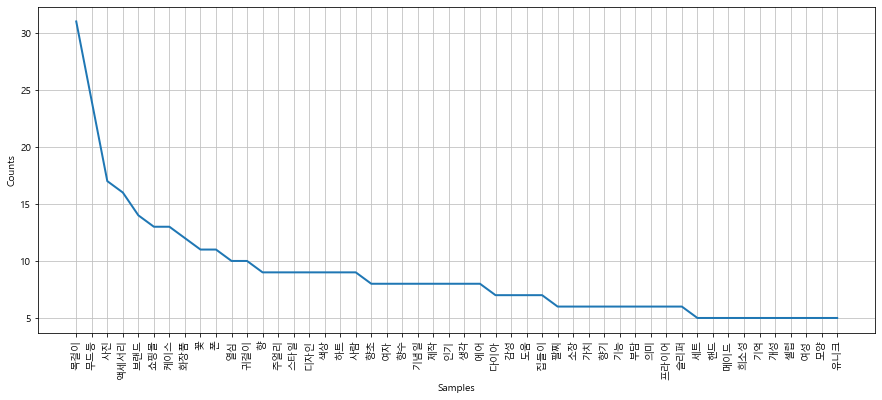

In [11]:
# 빈도수 그래프
plt.figure(figsize=(15,6))
ko.plot(50)
plt.show()

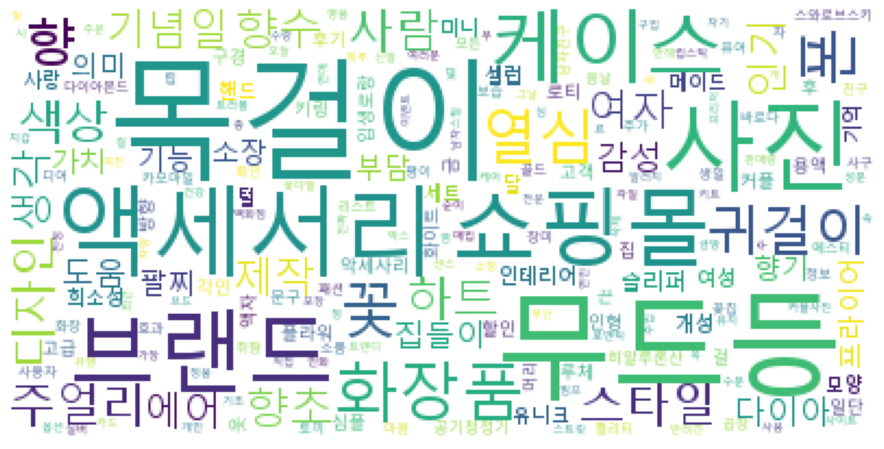

In [12]:
# 일반적인 클라우드
data = ko.vocab().most_common(300)

wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                        relative_scaling=0.5,
                        background_color='white',
                        ).generate_from_frequencies(dict(data))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [13]:
mask = np.array(Image.open('./data/heart.jpg'))

from wordcloud import ImageColorGenerator

image_colors = ImageColorGenerator(mask)

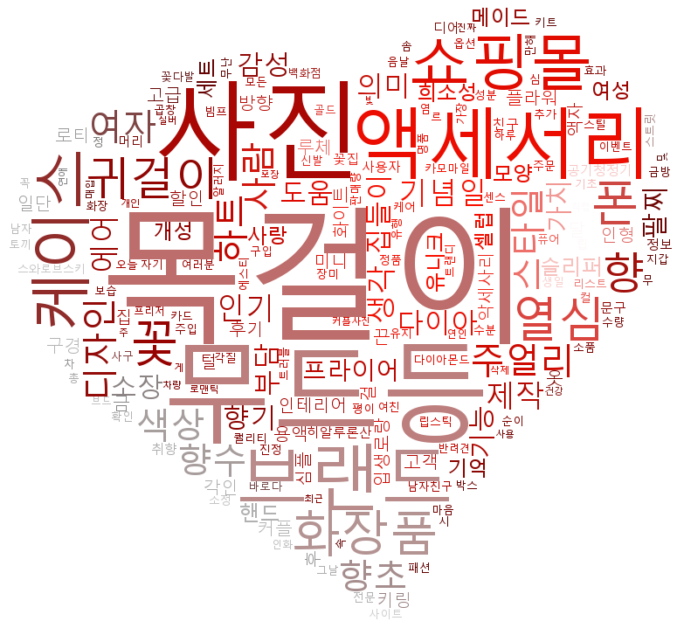

In [14]:
data = ko.vocab().most_common(200)

wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                        relative_scaling=0.1,mask=mask,
                        background_color='white',
                        ).generate_from_frequencies(dict(data))
default_colors = wordcloud.to_array()
plt.figure(figsize=(12,12))
plt.imshow(wordcloud.recolor(color_func=image_colors),interpolation='bilinear')
plt.axis('off')
plt.show()